Define parameters

In [6]:
checkpoint_directory = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_medgan"
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
checkpoint_directory_ae = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_ae_4"
# checkpoint_directory_ae_output = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_ae_5"
checkpoint_prefix_ae = os.path.join(checkpoint_directory_ae, "ckpt")

GIT_USERNAME = "dado330"
GIT_MAIL = "messina.davide.statistician@gmail.com"
GIT_REPO = "https://github.com/dado330/AE-WGAN-GP"

In [ ]:

data = np.load("/content/gdrive/My Drive/Colab_Notebooks/D3_events_ALL_OUTCOMES_ML.npy", allow_pickle=True)
train_data, test_data = train_test_split(data, test_size=0.1)

Git parameter to be run only once

In [7]:
!git clone $GIT_REPO
!git config --global user.email $GIT_MAIL
!git config --global user.name $GIT_USERNAME

Cloning into 'AE-WGAN-GP'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 5), reused 19 (delta 4), pack-reused 0
Receiving objects: 100% (23/23), 9.30 MiB | 27.30 MiB/s, done.
Resolving deltas: 100% (5/5), done.
fatal: not a git repository (or any of the parent directories): .git


Pull changes before running the script

In [9]:
%%bash
cd /content/AE-WGAN-GP
git pull origin main

Already up to date.


From https://github.com/dado330/AE-WGAN-GP
 * branch            main       -> FETCH_HEAD


In [ ]:
%%bash
cd /content/AE-WGAN-GP
git add -A
git commit -m "first commit"
git push -u origin main

In [ ]:
d_AE = "/content/AE-WGAN-GP/AE_checkpoints/"
d_WGAN = "/content/AE-WGAN-GP/WGAN-GP_checkpoints/"
d_data = "/content/AE-WGAN-GP/Input_data/"
!mkdir -p $d_AE && cp "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_ae_4/." $d_AE -r
!mkdir -p $d_WGAN && cp "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_medgan/." $d_WGAN -r
!mkdir -p $d_data && cp "/content/gdrive/My Drive/Colab_Notebooks/D3_events_ALL_OUTCOMES_ML.npy" $d_data -r
!mkdir -p $d_data && cp "/content/gdrive/My Drive/Colab Notebooks/Copy of Untitled1.ipynb" $d_data -r

Import necessary packages and functions

In [3]:
import os
import pickle
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

Attach google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Check if GPU has been loaded correctly

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Definition of encoder: input is with dimension 18 and has four dense layers of increasing size 64, 128, 256, 512

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.Encoder_DIMS = [64, 128, 256, 512]
        self.dense_layers = [tf.keras.layers.Dense(dim, activation=tf.nn.selu, kernel_regularizer='l1')
                             for dim in self.Encoder_DIMS[:-1]]
        self.output_layer = tf.keras.layers.Dense(self.Encoder_DIMS[-1], activation=tf.nn.sigmoid)

    def call(self, x):
        for s in range(len(self.dense_layers)):
            x = self.dense_layers[s](x)
        x = self.output_layer(x)
        return x

Definition of decoder: input is with dimension 512 and has four dense layers of decreasing size 256, 128, 64, 18

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.Decoder_DIMS = [256, 128, 64, 18]
        self.dense_layers = [tf.keras.layers.Dense(dim, activation=tf.nn.selu, kernel_regularizer='l1')
                             for dim in self.Decoder_DIMS[:-1]]
        self.output_layer = tf.keras.layers.Dense(self.Decoder_DIMS[-1], activation=tf.nn.sigmoid)

    def call(self, x):
        for j in range(len(self.dense_layers)):
            x = self.dense_layers[j](x)
        x = self.output_layer(x)
        return x

Definition of generator: input is with dimension 512 and has three dense layers of fixed size 512

In [ ]:
class Generator(tf.keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.G_DIMS = [512, 512, 512]
        self.batch_norm_layers = [tf.keras.layers.BatchNormalization(epsilon=1e-5) for _ in self.G_DIMS[:-1]]
        self.dense_layers = [tf.keras.layers.Dense(dim, activation=tf.nn.selu, kernel_regularizer='l1')
                             for dim in self.G_DIMS[1:-1]]
        self.output_layer = tf.keras.layers.Dense(self.G_DIMS[-1], activation=tf.nn.sigmoid)

    def call(self, x, training):
        for k in range(0, len(self.G_DIMS[:-2])):
            x1 = self.dense_layers[k](self.batch_norm_layers[k](x, training=training))
            x += tf.keras.layers.Add()([x1, x])
        x2 = self.output_layer(self.batch_norm_layers[-1](x, training=training))
        x += tf.keras.layers.Add()([x2, x])
        return x

Definition of discriminator: input is with dimension 512 and has five dense layers of decreasing size 256, 128, 64, 32, 1

In [ ]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.D_DIMS = [256, 128, 64, 32]
        self.dense_layers = [tf.keras.layers.Dense(dim, activation=tf.nn.selu) for dim in self.D_DIMS]
        self.output_layer = tf.keras.layers.Dense(1)

    def call(self, x):
        for h in range(len(self.D_DIMS)):
            x = self.dense_layers[h](x)
        x = self.output_layer(x)
        return x

Define a custom learning rate scheduler

In [ ]:
def set_learning_rate(epoch):
    if epoch > 500:
        ae_optimizer.learning_rate = 1e-4
    elif epoch > 50:
        ae_optimizer.learning_rate = 3e-4
    elif epoch > 3:
        ae_optimizer.learning_rate = 6e-4

Define the gp (gradient penalty)

In [ ]:
def gradient_penalty(batch_size, real_data, fake_data):
    """Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """
    # Get the interpolated image
    real_data = tf.cast(real_data, tf.float32)
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    diff = real_data - fake_data
    interpolated = fake_data + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp

Define the training step for the autoencoder

In [ ]:
def ae_step(real):
    with (tf.GradientTape() as disc_tape):
        synthetic = decoder(encoder(real))

        main_sparsity_penalty = - tf.math.log(tf.reduce_mean(synthetic + 1e-10)) + tf.math.log(
            tf.reduce_mean(tf.cast(real, tf.float32) + 1e-10))
        sparsity_penalty = - tf.math.log(1 - main_sparsity_penalty)
        autoenc_loss = tf.cast(bce(synthetic, real), tf.float32) + sparsity_penalty
        if np.random.uniform(size=1) > 0.999:
            print("synthetic")
            print(tf.round(synthetic).numpy())
            print("real")
            print(real.numpy())

    gradients_of_autoencoder = disc_tape.gradient(autoenc_loss,
                                                  encoder.trainable_variables + decoder.trainable_variables)
    ae_optimizer.apply_gradients(zip(gradients_of_autoencoder,
                                     encoder.trainable_variables + decoder.trainable_variables))
    return autoenc_loss

Define the training step for the discriminator/critic

In [ ]:
def d_step(real):
    z = tf.random.normal(shape=[batchsize, Z_DIM])
    gp_weight = 10

    with tf.GradientTape() as disc_tape:
        synthetic = decoder(generator(z, training=False))

        real_output = discriminator(real)
        fake_output = discriminator(synthetic)

        disc_cost = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

        gp = gradient_penalty(batchsize, real, synthetic)

        disc_loss = disc_cost + gp * gp_weight

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return disc_loss

Define the training step for the generator

In [ ]:
def g_step():
    z = tf.random.normal(shape=[batchsize, Z_DIM])
    with tf.GradientTape() as gen_tape:
        synthetic = decoder(generator(z, training=True))

        fake_output = discriminator(synthetic)

        gen_loss = -tf.reduce_mean(fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables + decoder.non_trainable_variables)
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables + decoder.non_trainable_variables))
    return gen_loss

In [ ]:
def train():
    checkpoint_directory = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_medgan"
    checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
    checkpoint_directory_ae = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_ae_4"
    # checkpoint_directory_ae_output = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_ae_5"
    checkpoint_prefix_ae = os.path.join(checkpoint_directory_ae, "ckpt")
    data = np.load("/content/gdrive/My Drive/Colab_Notebooks/D3_events_ALL_OUTCOMES_ML.npy", allow_pickle=True)
    train_data, test_data = train_test_split(data, test_size=0.1)
    dataset_train = tf.data.Dataset.from_tensor_slices(train_data).shuffle(
        1000, reshuffle_each_iteration=True).batch(batchsize, drop_remainder=True)
    steps = len(dataset_train)

    ae_optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0004,
                                             beta_1=0.7, beta_2=0.99)
    generator_optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0004,
                                                    beta_1=0, beta_2=0.9)
    discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.0004,
                                                        beta_1=0, beta_2=0.9)

    generator = Generator()
    discriminator = Discriminator()
    encoder = Encoder()
    decoder = Decoder()

    dloss_list = list()
    gloss_list = list()

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    checkpoint_ae = tf.train.Checkpoint(encoder=encoder, decoder=decoder)

    checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder, generator=generator, discriminator=discriminator)
    manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_directory, max_to_keep=5)

    # def reinitialize(model):
    #     for l in model.layers:
    #         if hasattr(l, "kernel_initializer"):
    #             l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
    #         if hasattr(l, "bias_initializer"):
    #             l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
    #         if hasattr(l, "recurrent_initializer"):
    #             l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

    # epochs = 1000
    # for epoch in range(epochs):
    #     set_learning_rate(epoch)
    #     start_time = time.time()
    #     aeloss = 0.0
    #     for batch_sample in dataset_train:
    #         aeloss += ae_step(batch_sample)
    #     duration_epoch_ae = time.time() - start_time
    #     format_str = 'epoch: %d, aeloss = %.3f (%.2f)'
    #     print(format_str % (epoch, aeloss / steps * 1000, duration_epoch_ae))
    #     if (aeloss.numpy() < 0.001) & epoch == (epochs - 1):
    #         checkpoint_ae.save(file_prefix=checkpoint_prefix_ae)

    # checkpoint_ae.save(file_prefix=checkpoint_directory_ae_output)

    # start_time = time.time()
    # aeloss = ae_step(test_data)
    # duration_epoch_ae = time.time() - start_time
    # format_str = 'epoch: %d, test_aeloss = %.3f (%.2f)'
    # print(format_str % (epoch, aeloss * 1000, duration_epoch_ae))

    checkpoint_ae.restore(checkpoint_prefix_ae + '-1').expect_partial()
    decoder.trainable = False
    restore_results = False

    if restore_results:
        checkpoint.restore(manager.latest_checkpoint).expect_partial().assert_existing_objects_matched()
        # checkpoint.restore(manager.latest_checkpoint).expect_partial().assert_consumed()
        with open(os.path.join(checkpoint_directory, "dloss.pkl"), 'rb') as f:
            dloss_list = pickle.load(f)
        with open(os.path.join(checkpoint_directory, "gloss.pkl"), 'rb') as f:
            gloss_list = pickle.load(f)

    for epoch in range(10000):
        start_time = time.time()
        dloss = 0.0
        gloss = 0.0
        step = 0.0
        d_iter = 5
        for batch_sample in dataset_train:
            for _ in range(d_iter):
                dloss += d_step(batch_sample)
            gloss += g_step()
            step += 1

        dloss_list.append(round(dloss.numpy() / (step * d_iter) * 1000, 1))
        gloss_list.append(round(gloss.numpy() / step * 1000, 1))

        duration_epoch = time.time() - start_time
        format_str = 'epoch: %d, dloss = %.1f, gloss = %.1f, total_loss = %.1f (%.2f)'
        print(format_str % (epoch, dloss / (step * d_iter) * 1000, gloss / step * 1000,
         (dloss + gloss) / step * 1000, duration_epoch))

    manager.save()
    with open(os.path.join(checkpoint_directory, "dloss.pkl"), 'wb') as f:  # open a text file
        pickle.dump(dloss_list, f)  # serialize the list
    with open(os.path.join(checkpoint_directory, "gloss.pkl"), 'wb') as f:  # open a text file
        pickle.dump(gloss_list, f)  # serialize the list


def gen():
    checkpoint_directory = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_medgan"
    checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
    generator = Generator()
    encoder = Encoder()
    decoder = Decoder()
    discriminator = Discriminator()
    checkpoint = tf.train.Checkpoint(encoder=encoder, decoder=decoder, generator=generator, discriminator=discriminator)

    manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_directory, max_to_keep=5)
    checkpoint.restore(manager.latest_checkpoint).expect_partial().assert_existing_objects_matched()

    @tf.function
    def g_step():
        z = tf.random.normal(shape=[batchsize, Z_DIM])
        synthetic = decoder(generator(z, training=False))

        return synthetic

    synthetic = g_step()
    syn = discriminator(synthetic)
    print(tf.round(synthetic))
    format_str = 'percentage of generated data classified as true: %d%%'
    print(format_str % (np.sum(tf.round(syn) == 0) / batchsize * 100))
    y = tf.gather(tf.round(synthetic), tf.where(tf.squeeze(tf.round(syn) == 0)))
    print(tf.squeeze(y))

    # np.save('syn/medgan', synthetic.numpy())


if __name__ == '__main__':
    batchsize = 20
    Z_DIM = 512
    random.seed(123)
    # parser = argparse.ArgumentParser()
    # parser.add_argument('gpu', type=str)
    # args = parser.parse_args()
    # os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    # os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu
    # os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    # gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    # for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)
    for i in range(1):
        # train()
        gen()
    # gen(args.n, args.epoch)


tf.Tensor(
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 

In [ ]:
!cp /content/training_checkpoints_ae_4 /content/gdrive/MyDrive/Colab_Notebooks -r

In [ ]:


encoder = Encoder()
encoder.summary()

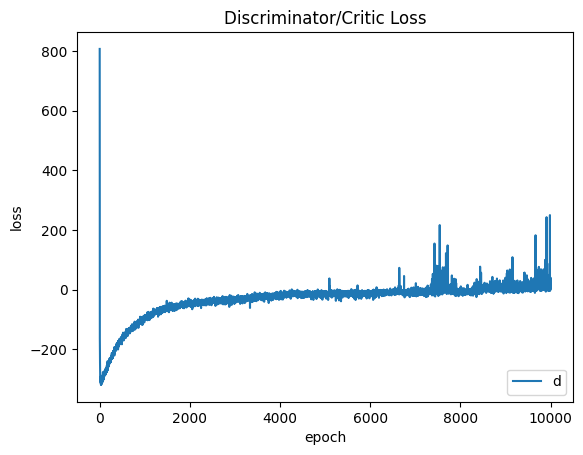

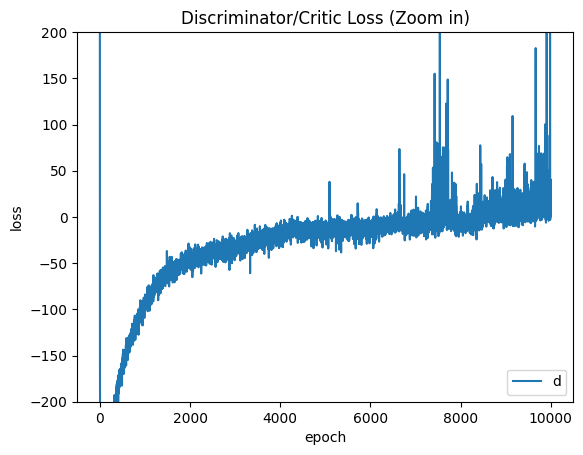

In [ ]:
checkpoint_directory = "/content/gdrive/My Drive/Colab_Notebooks/training_checkpoints_medgan"
with open(os.path.join(checkpoint_directory, "dloss.pkl"), 'rb') as f:
  dloss_list = pickle.load(f)
fig, ax = plt.subplots()
ax.plot(dloss_list)
plt.title('Discriminator/Critic Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('d-loss', loc='lower right')
plt.show()
fig, ax = plt.subplots()
ax.plot(dloss_list)
ax.set_ylim(-200, 200)
plt.title('Discriminator/Critic Loss (Zoom in)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('d-loss', loc='lower right')
plt.show()

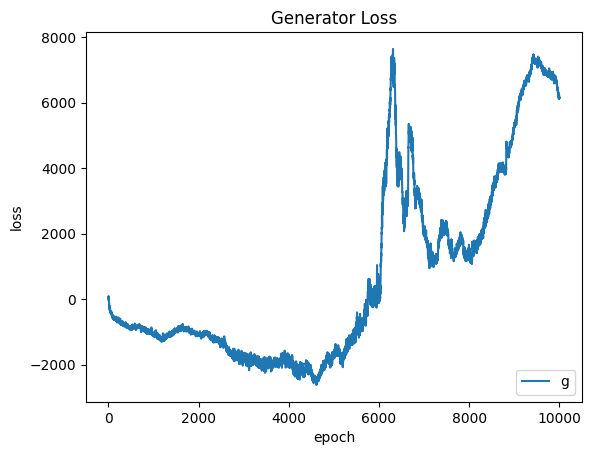

In [ ]:
with open(os.path.join(checkpoint_directory, "gloss.pkl"), 'rb') as f:
  gloss_list = pickle.load(f)
plt.plot(gloss_list)
plt.title('Generator Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('g-loss', loc='lower right')
plt.show()